# Lab 3. Basic NN RL methods

## Part 1. Q-network for Cart-Pole

1. Implement DQN and tune it to have stable learning under 1000 episodes. At least try to change
- epsilon decay
- number and a size of the hidden layers in the model
- learning rate (you can use schedulers)
- replay size, and frequency of calling memory replay

2. Implement Target Network

## Part 2. (see below)

## Requirements

- Soft deadline: 19.11 23:59
- Hard dealind: 22.11 23:59

https://apxml.com/courses/intermediate-reinforcement-learning/chapter-2-deep-q-networks-dqn/dqn-cartpole-practical

In [460]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch import distributions
from collections import deque
import torchvision.transforms as T
import gymnasium as gym, math
import copy
import math
import time
import numpy as np
import random
from collections import deque
from torch.optim.lr_scheduler import StepLR, ExponentialLR, ReduceLROnPlateau

### Replay buffer

In [461]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards),
            np.array(next_states),
            np.array(dones)
        )
    
    def __len__(self):
        return len(self.buffer)

In [462]:
!pip install gymnasium[classic-control] pyvirtualdisplay
!apt-get install -y xvfb python-opengl ffmpeg

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [463]:
import matplotlib.pyplot as plt
%matplotlib inline

from IPython import display
from pyvirtualdisplay import Display
d = Display(visible=0, size=(400, 300))
d.start()

def show_state(env, episode=0, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Eposide: %d | Step: %d %s" % ('Cart-pole-v1', episode, step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())


## DQN with experience replay

In [464]:
class DQN():
    ''' Deep Q Neural Network class. '''
    def __init__(self, state_dim, action_dim, hidden_dim=128,
                buffer_size=10000, batch_size=64, gamma=0.99, device=None, alpha=0.001):
            
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

            self.criterion = nn.MSELoss()

            self.model = nn.Sequential(
                nn.Linear(state_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, action_dim)
            ).to(self.device)


            self.target_model = nn.Sequential(
                nn.Linear(state_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, action_dim)
            ).to(self.device)

            def init_weights(m):
                if isinstance(m, nn.Linear):
                    # layer cuối
                    if m.out_features == action_dim:
                        nn.init.uniform_(m.weight, -1e-3, 1e-3)
                        nn.init.zeros_(m.bias)
                    else:
                        # hidden layers
                        nn.init.xavier_uniform_(m.weight)
                        nn.init.zeros_(m.bias)
            self.model.apply(init_weights)
            self.target_model.apply(init_weights)

            # self.optimizer = optim.Adam(self.model.parameters(), lr=alpha)

            self.action_dim = action_dim
            self.losses = []
            self.buffer_size = buffer_size
            self.replay_buffer = ReplayBuffer(self.buffer_size)
            self.batch_size = batch_size
            self.gamma = gamma

            self.optimizer = optim.Adam(self.model.parameters(), lr=alpha)
            # self.scheduler = StepLR(self.optimizer, step_size=50, gamma=0.92)
            self.scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.9996)

    def update(self, states, actions, target_q_values):
        """Update the weights of the network given a training sample (batch). """
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device) # Should be long tensor
        target_q_values = torch.FloatTensor(target_q_values).to(self.device)
        
        # Q values for all actions
        q_pred = self.model(states)  # Shape: [batch_size, action_dim]
        
        # Take Q-values of actions
        q_pred_action = q_pred.gather(1, actions.unsqueeze(1)).squeeze(-1)  # Shape: [batch_size]
        
        # Tính loss
        loss = self.criterion(q_pred_action, target_q_values)
        self.losses.append(loss.item())

        # Backprop
        self.optimizer.zero_grad()
        loss.backward()

        # Gradient clipping 
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
        self.optimizer.step()
        self.scheduler.step()

        return loss.item()

    def train_step(self):
        """Training with experience replay"""
        if len(self.replay_buffer) < self.batch_size:
             return None
        
        # Sample batch from replay buffer
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        
        # Convert to tensor
        states = torch.FloatTensor(states).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)  
        rewards = torch.FloatTensor(rewards).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)
        
        # Calculations target Q-values
        with torch.no_grad():
            next_q = self.model(next_states).max(1)[0]  # Max Q-value of next_state
            target_q_values = rewards + self.gamma * next_q * (1 - dones)

        loss = self.update(states.cpu().numpy(), actions.cpu().numpy(), target_q_values.cpu().numpy())
        return loss
    
    def train_step_with_target_network(self):
        if len(self.replay_buffer) < self.batch_size:
            return None
        
        # Sample a batch from replay buffer
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        
        # Convert to tensors
        states = torch.FloatTensor(states).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)  
        rewards = torch.FloatTensor(rewards).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)
        
        # Calculate target Q-values using target network (KEY DIFFERENCE)
        with torch.no_grad():
            # Use target network to compute max Q-value for next states
            next_q = self.target_model(next_states).max(1)[0]
            target_q_values = rewards + self.gamma * next_q * (1 - dones)
        
        loss = self.update(states.cpu().numpy(), actions.cpu().numpy(), target_q_values.cpu().numpy())
        return loss

    def update_target_network(self):
        """Copy weights from main network to target network."""
        self.target_model.load_state_dict(self.model.state_dict())
    
    
    def select_action(self, state, epsilon):
        """Epsilon-greedy action selection"""
        if random.random() < epsilon:
            return random.randint(0, self.action_dim - 1)  # Explore
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                q_values = self.model(state_tensor)
                return q_values.argmax(dim=1).item() 
            
    def predict(self, state):
        """ Compute Q values for all actions using the DQL. """
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).to(self.device) 
            return self.model(state_tensor)

In [465]:
def plot_results(rewards, moving_avg, losses):
    """Plot results training"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Plot rewards
    ax1.plot(rewards, alpha=0.3, color='blue', label='Episode Reward')
    if moving_avg:
        ax1.plot(range(99, len(rewards)), moving_avg, color='red', 
                linewidth=2, label='Moving Average (100 eps)')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')
    ax1.set_title('Training Rewards over Episodes')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot losses
    ax2.plot(losses, alpha=0.6, color='green')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Average Loss')
    ax2.set_title('Training Loss over Episodes')
    ax2.grid(True, alpha=0.3)

    plt.show()

In [466]:
def train_dqn_with_replay(episodes = 1000, max_steps=200, hidden_dim=64, buffer_size=20000, learning_rate=1e-4,
                        batch_size=32, gamma = 0.99, epsilon_decay = 0.996, qtarget_flag=False, target_update_freq=None):
    """
    Training DQN for Cart Pole
    """
    # Initial enviroment
    env = gym.make('CartPole-v1')
    state_dim = env.observation_space.shape[0] # 4
    action_dim = env.action_space.n  # 2
    print(f"State dim: {state_dim}, Action dim: {action_dim}")

    # DQN 
    model = DQN(state_dim, action_dim, 
                hidden_dim=hidden_dim,
                buffer_size=buffer_size,
                batch_size=batch_size,
                gamma=gamma,
                alpha=learning_rate
            )
    
    # Epsilon decay cho exploration
    epsilon = 1.0
    min_epsilon = 0.01
    epsilon_decay = 0.996
    # For saving result
    episode_rewards = []
    episode_losses = []
    moving_avg_rewards = []
    learning_rates = []

    print("Start training ...\n")
    
    if qtarget_flag:
        print("Training with q target network! .....")

    for episode in range(episodes):
        state, _ = env.reset()

        episode_reward = 0.0
        episode_loss = []
        frequenc = 0 

        for step in range(max_steps):
            frequenc += 1
            action = model.select_action(state, epsilon)
            # Implementation action
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            # save to buffer
            model.replay_buffer.push(state, action, reward, next_state, float(done))
            # Training
            if frequenc % 5 == 0:
                # Handle training with q target network or not
                if qtarget_flag:
                    loss = model.train_step_with_target_network()
                else: 
                    loss = model.train_step()
                
                if loss is not None:
                    episode_loss.append(loss)
            episode_reward += reward 
            state = next_state

            if done:
                break  
      
        if qtarget_flag and target_update_freq is not None:
            if (episode + 1) % target_update_freq == 0:
                model.update_target_network()
        # Epsilon decay
        epsilon = max(epsilon*epsilon_decay, min_epsilon)
        # model.scheduler.step() 
        current_lr = model.optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        # Saving result
        episode_rewards.append(episode_reward)
        avg_loss = np.mean(episode_loss) if episode_loss else 0.0
        episode_losses.append(avg_loss)

        window = 100
        if len(episode_rewards) >= window:
            moving_avg = np.mean(episode_rewards[-window:])
            moving_avg_rewards.append(moving_avg)
        
        # Print result
        if (episode + 1) % 50 == 0:
            avg_reward = np.mean(episode_rewards[-50:])
            avg_loss = np.mean(episode_loss) if episode_loss else 0
            print(f"Episode {episode+1:3d} | Reward: {episode_reward:5.1f} | "
                  f"Avg(50): {avg_reward:5.1f} | Loss: {avg_loss:.4f} | "
                  f"LR: {current_lr:.10f} | ε: {epsilon:.3f}")
    env.close()

    plot_results(episode_rewards, moving_avg_rewards, episode_losses)

    return model, episode_rewards

def test_agent(model, num_episodes=10, render=False):
    
    """Testing trained model"""

    env = gym.make("CartPole-v1", render_mode='human' if render else None)
    test_rewards = []

    for episode in range(num_episodes):

        state, _ = env.reset()
        episode_reward = 0
        done = False

        while not done:
            # epsilon == 0.0 => using action from model
            action = model.select_action(state, epsilon=0.0)  # Greedy

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            episode_reward += reward
            state = next_state
        test_rewards.append(episode_reward)
    env.close()
    # print(f"\n Average test reward: {np.mean(test_rewards):.2f} ± {np.std(test_rewards):.2f}")
    return test_rewards

State dim: 4, Action dim: 2
Start training ...

Episode  50 | Reward:  32.0 | Avg(50):  20.3 | Loss: 215.7580 | LR: 0.0009331271 | ε: 0.818
Episode 100 | Reward:  14.0 | Avg(50):  19.7 | Loss: 205.5515 | LR: 0.0008696818 | ε: 0.670
Episode 150 | Reward:  14.0 | Avg(50):  14.0 | Loss: 92.8520 | LR: 0.0008295786 | ε: 0.548
Episode 200 | Reward:  11.0 | Avg(50):  13.7 | Loss: 32.6120 | LR: 0.0007913248 | ε: 0.449
Episode 250 | Reward:  14.0 | Avg(50):  12.8 | Loss: 5.6804 | LR: 0.0007572547 | ε: 0.367
Episode 300 | Reward:  59.0 | Avg(50):  26.7 | Loss: 18.2262 | LR: 0.0006865507 | ε: 0.300
Episode 350 | Reward:  37.0 | Avg(50):  48.8 | Loss: 54.1531 | LR: 0.0005700037 | ε: 0.246
Episode 400 | Reward:  59.0 | Avg(50):  72.1 | Loss: 39.8435 | LR: 0.0004307754 | ε: 0.201
Episode 450 | Reward:  62.0 | Avg(50):  87.3 | Loss: 249.5232 | LR: 0.0003064697 | ε: 0.165
Episode 500 | Reward:  50.0 | Avg(50): 107.1 | Loss: 101.1313 | LR: 0.0002013480 | ε: 0.135
Episode 550 | Reward:  52.0 | Avg(50): 

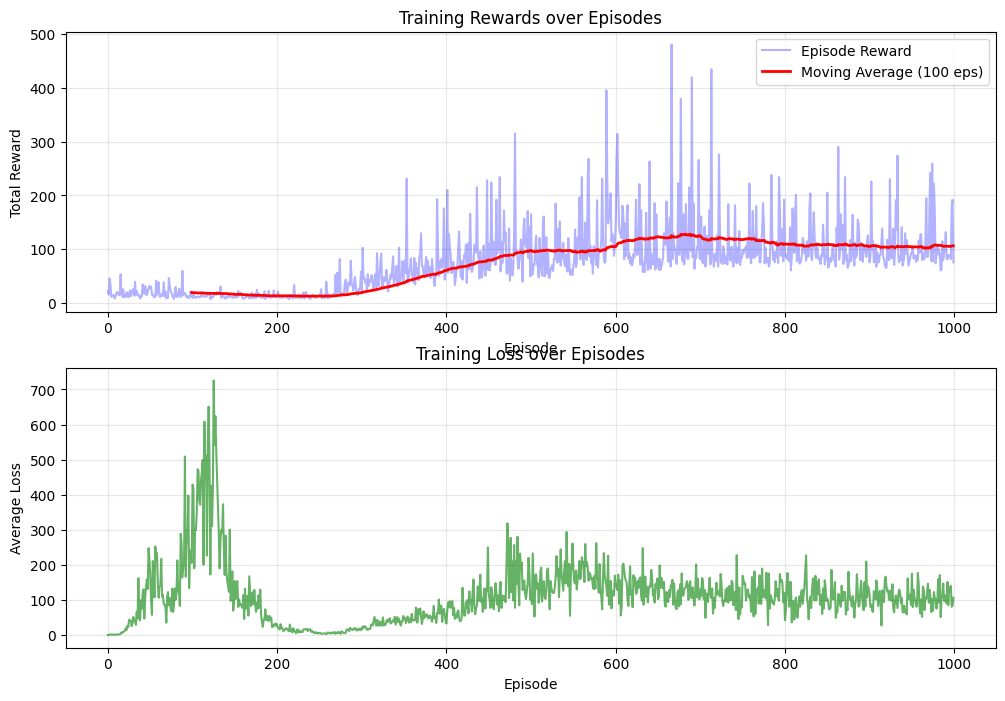

In [467]:
# without q target network
model, episode_rewards = train_dqn_with_replay(episodes=1000, max_steps=500, hidden_dim=128,
                      buffer_size=50000, learning_rate=1e-3,
                      batch_size=64, gamma=0.99, epsilon_decay = 0.996, qtarget_flag=False, target_update_freq=None)

## **Implement DQN with Target Network**

State dim: 4, Action dim: 2
Start training ...

Training with q target network! .....
Episode  50 | Reward:  16.0 | Avg(50):  24.5 | Loss: 10.2149 | LR: 0.0045897281 | ε: 0.818
Episode 100 | Reward:  19.0 | Avg(50):  35.8 | Loss: 28.3949 | LR: 0.0040124174 | ε: 0.670
Episode 150 | Reward:  27.0 | Avg(50):  66.1 | Loss: 50.8906 | LR: 0.0031060216 | ε: 0.548
Episode 200 | Reward: 299.0 | Avg(50): 148.5 | Loss: 31.1832 | LR: 0.0017256868 | ε: 0.449
Episode 250 | Reward:  59.0 | Avg(50): 157.2 | Loss: 38.4654 | LR: 0.0009270951 | ε: 0.367
Episode 300 | Reward: 284.0 | Avg(50): 237.7 | Loss: 24.0559 | LR: 0.0003613575 | ε: 0.300
Episode 350 | Reward: 165.0 | Avg(50): 242.4 | Loss: 43.0116 | LR: 0.0001381134 | ε: 0.246
Episode 400 | Reward: 229.0 | Avg(50): 259.9 | Loss: 5.3688 | LR: 0.0000491988 | ε: 0.201
Episode 450 | Reward: 276.0 | Avg(50): 249.5 | Loss: 2.6542 | LR: 0.0000182921 | ε: 0.165
Episode 500 | Reward: 237.0 | Avg(50): 243.4 | Loss: 2.0377 | LR: 0.0000069635 | ε: 0.135


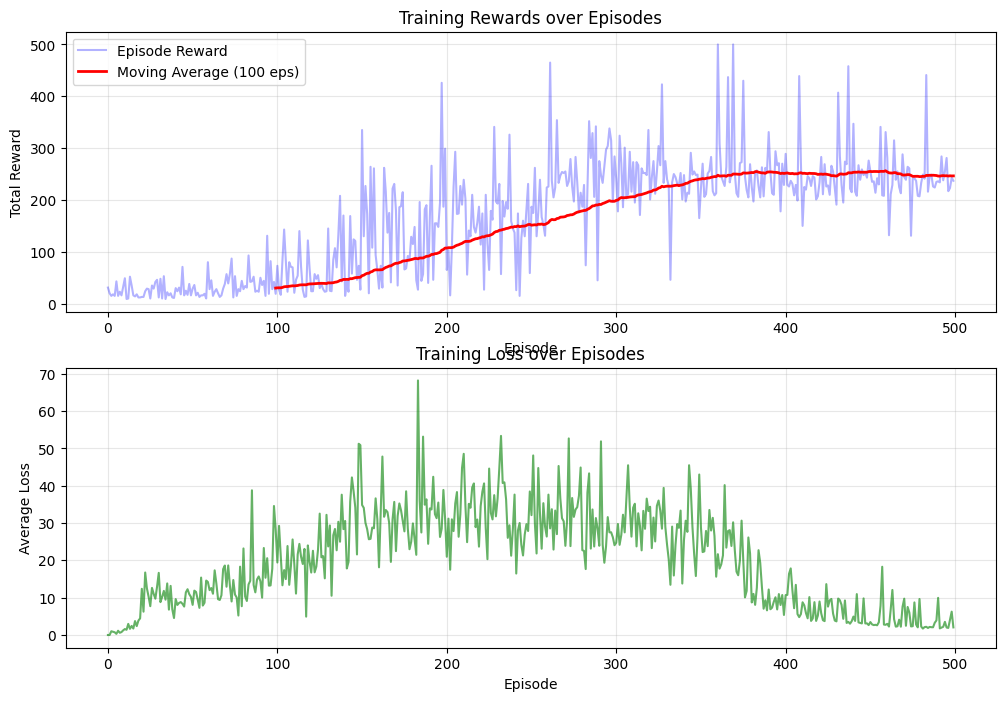

In [468]:
# with q target network
model01, episode_rewards = train_dqn_with_replay(episodes=500, max_steps=500, hidden_dim=128,
                      buffer_size=50000, learning_rate=5e-3,
                      batch_size=64, gamma=0.99, epsilon_decay = 0.995, qtarget_flag=True, target_update_freq=2)

In [469]:
# Result with q target network
reward = test_agent(model01, num_episodes=100, render=False)
average_reward = np.mean(reward)
print(f"Average reward over 100 test episodes: {average_reward:.2f}")

Average reward over 100 test episodes: 241.80


In [470]:
# Result without q target network
reward = test_agent(model, num_episodes=100, render=False)
average_reward = np.mean(reward)
print(f"Average reward over 100 test episodes: {average_reward:.2f}")

Average reward over 100 test episodes: 122.82


## **Part 2. Simple Policy Gradient for Cart-Pole**
1. Implement [Simple PG](https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html) and tune it to have stable learning under 2000 episodes. At least try to change
- epsilon decay
- number and a size of the hidden layers in the model
- learning rate (you can use schedulers)
- batch size

2. Implement Reward-To-Go

In [ ]:
class PG():
    def __init__(self, state_dim, action_dim, hidden_dim=12, alpha=0.001):
        self.model = # your code here

        self.optimizer = # your code here
        # self.scheduler = # your code here

    def get_policy(self, obs):
        state = torch.FloatTensor(obs)
        logits = self.model(state)
        return distributions.Categorical(logits=logits)

    def get_action(self, obs):
        return # your code here

    def update(self, batch_states, batch_actions, batch_weights):
        self.optimizer.zero_grad()

        # your code here

        loss.backward()
        self.optimizer.step()

In [ ]:
#
vpg_n_hidden = 16
model_vpg = PG(n_states, n_actions, n_hidden, alpha)

#
batch_size = 1000

batch_states = []
batch_actions = []
batch_weights = []

episode_states = []
episode_actions = []
episode_rewards = []

epoch = 0

# Q-learning
for i_episode in range(EPISODES_MAX):
    observation = env.reset()
    state = observation

    rewards = 0
    episode_states = []
    episode_actions = []
    episode_rewards = []

    if i_episode > 200 and (i_episode + 1) % 50 == 0:
        # model1.scheduler.step()

    if (i_episode + 1) % 20 == 0:
        plt.figure(2)
        plt.clf()

        # We say that problem is solved, if the mean length of the last 50 episodes it greater th
        plt.plot([0,i_episode], [495, 495], label="threshold")
        plt.plot(range(0,i_episode), log_total_reward[0:i_episode], label="solution 1")
        plt.xlabel('episode')
        plt.ylabel('episode reward')
        plt.legend()
        plt.title('alpha={} epoch={}'.format(model1.scheduler.get_last_lr()[0], epoch))
        display.clear_output(wait=True)
        display.display(plt.gcf())

    for t in range(STEPS_MAX):
        action = # your code here
        observation, reward, done, info = env.step(action)

        rewards += reward
        next_state = observation

        episode_states.append(state)
        episode_actions.append(action)
        episode_rewards.append(reward)

        state = next_state

        if done:
            log_total_reward[i_episode] = rewards
            log_steps_number[i_episode] = t

            # your code here

            # Update policy

            break

print("done")